# Sales Data Analysis Of Electronic Store

- Data source from [keggle.com](https://www.kaggle.com/datasets/mkechinov/ecommerce-purchase-history-from-electronics-store)

### 1. Import Libraries

In [1]:
import pandas as pd
import os
from glob import glob
import datetime
import numpy as np
from matplotlib import pyplot as plt

### 2. Read and Merge all Data Files

In [2]:
filenames = glob(".\Sales_Data\Sales*.csv")

dfs = [pd.read_csv(f) for f in filenames]
sales_2019 = pd.concat(dfs)

### 3. Exploration of Data

In [3]:
shape = sales_2019.shape
nan = np.sum(sales_2019.isna())
dublicates = np.sum(sales_2019.duplicated())

print('shape: ',shape)
print('NaNs: ', nan, sep="\n")
print('Dublicates: ',dublicates)

sales_2019.head()

shape:  (186850, 6)
NaNs: 
Order ID            545
Product             545
Quantity Ordered    545
Price Each          545
Order Date          545
Purchase Address    545
dtype: int64
Dublicates:  1162


,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
0,176558,USB-C Charging Cable,2,11.95,04/19/19 08:46,"917 1st St, Dallas, TX 75001"
1,NaN,NaN,NaN,NaN,NaN,NaN
2,176559,Bose SoundSport Headphones,1,99.99,04/07/19 22:30,"682 Chestnut St, Boston, MA 02215"
3,176560,Google Phone,1,600,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001"
4,176560,Wired Headphones,1,11.99,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001"


### 4. Data Cleaning

In [4]:
sales_2019 = sales_2019.dropna(how='all')

print('NaNs: ',np.sum(sales_2019.isna()), sep='\n')
# rows with NaN's seem to contain only NaN's

print('Dublicates: ',np.sum(sales_2019.duplicated()))
# data set still contains duplicates

sales_2019 = sales_2019.drop_duplicates(ignore_index=True)

sales_2019 = sales_2019[sales_2019['Order Date'] != 'Order Date']
# (values == column name) created error when trying converting to 
# needed dtype, so they are filtered out

sales_2019['Order Date'] = pd.to_datetime(sales_2019['Order Date'])
sales_2019 = sales_2019.sort_values('Order Date')

NaNs: 
Order ID            0
Product             0
Quantity Ordered    0
Price Each          0
Order Date          0
Purchase Address    0
dtype: int64
Dublicates:  618


#### 4.1 Duplicates: 
- If a customer buys the same item several times, the number in the "Quantity ordered" column should be increased, not the number of orders. 
- If an item was ordered several times in different orders, a new "Order ID" should be assigned to each time. 
    - Under these prerequisites, the duplicates were removed. In a real case, this issue should be clarified with the responsible person.

### 5. Which Months Had the Most Sales

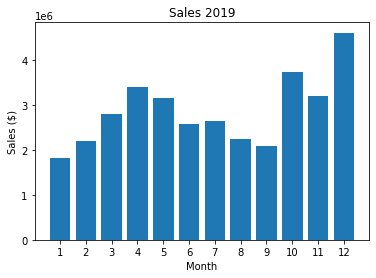

In [5]:
# extract the month from 'Order Date' column
sales_2019['Month'] = sales_2019['Order Date'].dt.month

sales_2019 = sales_2019.astype({'Month': 'int32', 'Price Each': 'float32', 'Quantity Ordered': 'float32'})

# creating 'Sales' column
sales_2019['Sales'] = sales_2019['Quantity Ordered']*sales_2019['Price Each']
sales_best_month = sales_2019.groupby('Month').sum('Sales').sort_values('Month', ascending=True)

# plot sales vs months
plt.bar(sales_best_month.index, sales_best_month['Sales'])
plt.xlabel('Month')
plt.ylabel('Sales ($)')
plt.xticks(ticks=sales_best_month.index)
plt.title('Sales 2019')
plt.show()

- The holidays seem to boost orders, especially before Christmas.

## 6. Which Cities Had the Most Sales?

Text(0.5, 1.0, 'Sales 2019')

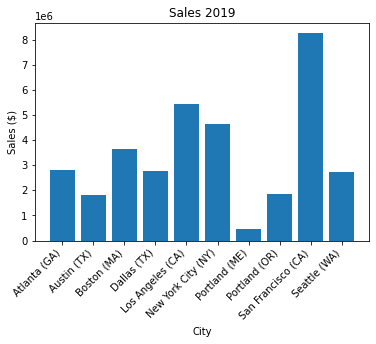

In [6]:
# Extract city + state from 'purchase address', since different states might contain the same city name
def get_city(address):
    return address.split(',')[1]

def get_state(address):
    return address.split(',')[2].split(' ')[1]

sales_2019['City_Zip'] = sales_2019['Purchase Address'].apply(lambda x: f"{get_city(x)} ({get_state(x)})")
sales_best_city = sales_2019.groupby('City_Zip')['Sales'].sum()

cities = sales_best_city.index

# plot sales vs city
plt.bar(cities, sales_best_city)
plt.xlabel('City')
plt.ylabel('Sales ($)')
plt.xticks(ticks=cities, rotation=45, ha='right')
plt.title('Sales 2019')

### 7. Which Product Sold the Most?

In [7]:
import warnings
warnings.filterwarnings('ignore')

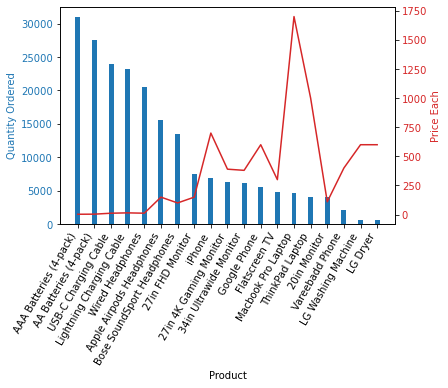

In [8]:
best_products = sales_2019.groupby('Product')['Quantity Ordered'].sum().sort_values(ascending=False)

products_price = sales_2019.groupby('Product')['Price Each'].mean()

best_products_price = pd.merge(best_products.reset_index(), products_price.reset_index(),
                               how='left', on=['Product'])

product = best_products_price['Product']
price = best_products_price['Price Each']
quantity = best_products_price['Quantity Ordered']

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Product')
ax1.set_xticklabels(product, rotation=60, ha='right')
ax1.set_ylabel('Quantity Ordered', color=color)
ax1.bar(product, quantity, color=color, width=0.3)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx() 

color = 'tab:red'
ax2.set_ylabel('Price Each', color=color)  
ax2.plot(product, price, color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.show()

- There is a clear trend that cheaper products are bought more often. The popularity of macbook and thinkpad laptops is interesting, despite the highest prices by far.

### 8. Top Three Products over 100 USD in Every City?

- The top three ranking for all products are more or less identical in each city, as presumably the demand for comparatively inexpensive and necessary commodities such as batteries and charging cables and the like might be stable across different population groups and income classes

In [9]:
sales_exp = sales_2019[sales_2019['Price Each'] >= 100]

city_product_quantity = sales_exp.groupby('City_Zip').apply(lambda x: x.groupby('Product')['Quantity Ordered']
                                         .sum().sort_values(ascending=False).head(3))

print(city_product_quantity)

City_Zip             Product                 
 Atlanta (GA)        Apple Airpods Headphones    1266.0
                     27in FHD Monitor             587.0
                     iPhone                       544.0
 Austin (TX)         Apple Airpods Headphones     884.0
                     iPhone                       377.0
                     27in FHD Monitor             358.0
 Boston (MA)         Apple Airpods Headphones    1651.0
                     27in FHD Monitor             797.0
                     iPhone                       752.0
 Dallas (TX)         Apple Airpods Headphones    1193.0
                     27in FHD Monitor             587.0
                     iPhone                       519.0
 Los Angeles (CA)    Apple Airpods Headphones    2468.0
                     27in FHD Monitor            1222.0
                     iPhone                      1118.0
 New York City (NY)  Apple Airpods Headphones    2094.0
                     27in FHD Monitor            1072.0
  

- Interestingly, Austin (TX) has the highest proportion of Iphones purchased and Portland (ME) has the lowest. This finding could be used for targeted marketing.

### 9. Time of Most Orders / Best Time for Advertisement?

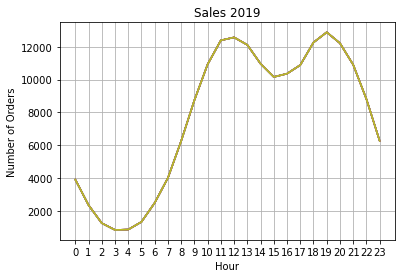

In [10]:
sales_2019['Order Date'] = pd.to_datetime(sales_2019['Order Date'])
sales_2019['Hour'] = sales_2019['Order Date'].dt.hour

hours = [hour for hour, df in sales_2019.groupby('Hour')]

plt.plot(hours, sales_2019.groupby('Hour').count())
plt.xlabel('Hour')
plt.ylabel('Number of Orders')
plt.xticks(ticks=hours)
plt.title('Sales 2019')
plt.grid()

- the number of orders peaks around 12 and 7 PM. The behavior could be related to the working hours. At 12 AM, many people have lunch break and at 7 AM, many are back home. 
- the most effective advertising would probably start 30 minutes before peaking above 12000 sales/hour

### 10. Which Combination Were Sold Most Often?

#### 10.1 Which Combination of 2wo Products?

In [11]:
# Products with the same order id are ordered together
df = sales_2019[sales_2019['Order ID'].duplicated(keep=False)]

# join different products into corresponding rows by 'Order ID' 
df['Grouped'] = df.groupby('Order ID')['Product'].transform(lambda x: ','.join(x))
df = df[['Order ID', 'Grouped']].drop_duplicates()

from itertools import combinations
from collections import Counter

count_2 = Counter()

for row in df['Grouped']:
    row_list = sorted(row.split(','), key=str.lower)
    count_2.update(Counter(combinations(row_list, 2)))

#https://stackoverflow.com/questions/67028695/how-to-count-specific-elements-inside-tuples-after-using-counter-python
# for more readability:
for key,value in count_2.most_common(10):
    print(key,': ', value)

('iPhone', 'Lightning Charging Cable') :  1011
('Google Phone', 'USB-C Charging Cable') :  997
('iPhone', 'Wired Headphones') :  462
('Google Phone', 'Wired Headphones') :  422
('Apple Airpods Headphones', 'iPhone') :  373
('USB-C Charging Cable', 'Vareebadd Phone') :  368
('Bose SoundSport Headphones', 'Google Phone') :  228
('USB-C Charging Cable', 'Wired Headphones') :  203
('Vareebadd Phone', 'Wired Headphones') :  149
('Lightning Charging Cable', 'Wired Headphones') :  129


#### 10.2 Which Combination of Three Products?

In [12]:
count_3 = Counter()

for row in df['Grouped']:
    row_list = sorted(row.split(','), key=str.lower)
    count_3.update(Counter(combinations(row_list, 3)))

for key,value in count_3.most_common(10):
    print(key,': ', value)

('Google Phone', 'USB-C Charging Cable', 'Wired Headphones') :  87
('iPhone', 'Lightning Charging Cable', 'Wired Headphones') :  63
('Apple Airpods Headphones', 'iPhone', 'Lightning Charging Cable') :  47
('Bose SoundSport Headphones', 'Google Phone', 'USB-C Charging Cable') :  35
('USB-C Charging Cable', 'Vareebadd Phone', 'Wired Headphones') :  33
('Apple Airpods Headphones', 'iPhone', 'Wired Headphones') :  27
('Bose SoundSport Headphones', 'Google Phone', 'Wired Headphones') :  24
('Bose SoundSport Headphones', 'USB-C Charging Cable', 'Vareebadd Phone') :  16
('Bose SoundSport Headphones', 'Vareebadd Phone', 'Wired Headphones') :  5
('Bose SoundSport Headphones', 'USB-C Charging Cable', 'Wired Headphones') :  5


- people bought most often phone + accessories together